# Naivní Bayesův klasifikátor

- základní varianta je pro kategoriální rysy
- založen na Baysově větě a naivním předpokladu podmíněné nezávislosti rysů

## Klasifikace emailů

*kategorie*: alt.atheism, comp.sys.mac.hardware, rec.motorcycles, sci.electronics, alk.politics.guns, comp.graphics, comp.windows.x, rec.sport.baseball, sci.med, talk.politics.mideast, comp.os.ms-windows.misc, misc.forsale,           rec.sport.hockey, sci.space, talk.politics.misccomp.sys.ibm.pc.hardware, rec.autos, sci.crypt,          soc.religion.christian, talk.religion.misc

... 20 kategorií -- pravěpodobnost, že se trefíme náhodou je $\frac{1}{20} = 5\%$

- jako rysy použijeme příznaky výskytu 4000 nejčastějších slov (zbavených nevýznamových, tzv. stop-slov)
- každý dokumnet je popsaný 4000 dimenzionálním binárním vektorem

In [11]:
## %matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import numpy as np
from scipy.sparse import csr_matrix, vstack
import csv
import matplotlib.pyplot as plt

X = []
y = []
f_data = open('data/newsgroup/newsgroup-4000.data')
for line in f_data:
    items = line.split(",")
    X.append(csr_matrix([int(x) for x in items[:-1]]))
    y.append(items[-1])
f_data.close()

X_train = vstack(X[:15000])
y_train = y[:15000]

X_test = vstack(X[15000:])
y_test = y[15000:]

In [12]:
import sklearn.naive_bayes

model = sklearn.naive_bayes.BernoulliNB()
model.fit(X_train, y_train)

train_acc = np.mean(model.predict(X_train) == y_train)
test_acc = np.mean(model.predict(X_test) == y_test)

print("training accuracy: {}".format(train_acc))
print("test accuracy:     {}".format(test_acc))

training accuracy: 0.7505333333333334
test accuracy:     0.6884130478286972


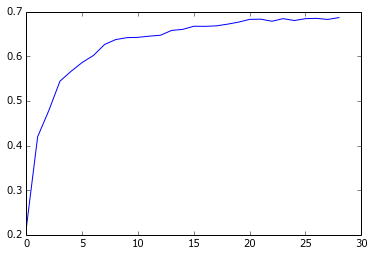

In [14]:
accuracies = []
for c in range(500, 15000, 500):
    X_c = vstack(X[:c])
    y_c = y[:c]
    model = sklearn.naive_bayes.BernoulliNB()
    model.fit(X_c, y_c)
    acc = np.mean(model.predict(X_test) == y_test)
    accuracies.append(acc)

ax = plt.gca()
ax.ticklabel_format(useOffset=False)
plt.plot(accuracies)    

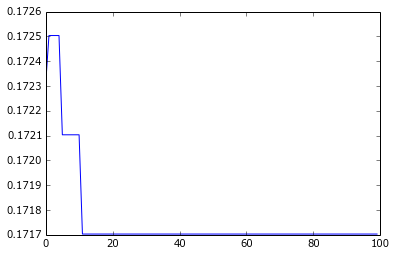

In [15]:
from nearpy import Engine
from nearpy.hashes import RandomBinaryProjections
from nearpy.distances import EuclideanDistance
from nearpy.filters import NearestFilter

def most_common(list):
    count = {}
    
    dist = {}
    for _, x, d in list:
        if not x in count:
            count[x] = 0
            dist[x] = 0
        count[x] += 1
        dist[x] += d
    if count:
        #return max(count.keys(), key=lambda x: count[x])
        return min(count.keys(), key=lambda x: dist[x] / count[x])
    else:
        return 'misc.forsale'

max_neighbors = 100
rbp = RandomBinaryProjections('rbp', 10)
knn_model = Engine(X[0].shape[1], lshashes=[rbp], 
                   distance=EuclideanDistance(),
                   vector_filters=[NearestFilter(max_neighbors)])
for x, y in zip(X[:15000], y_train):
    knn_model.store_vector(x.toarray().squeeze(), y)

predictions = [[] for _ in range(max_neighbors)]
for x in X[15000:]:
    neighbors = knn_model.neighbours(x.toarray().squeeze())
    for i in range(max_neighbors):
        predictions[i].append(most_common(neighbors[:i+1]))

accuracies = []
for i, pred in enumerate(predictions):
    accuracies.append(np.mean([p == y for p, y in zip(pred, y_test)]))

ax = plt.gca()
ax.ticklabel_format(useOffset=False)
plt.plot(accuracies)